In [190]:
# Simulador de Filtros
# Autores: Ramiro Belsito y Ignacio Sammartino
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import math
import sys

def ENG( valor: float, unidad: str) -> str:
    """
    Convierte un valor de resistencia o cself.Apacitancia a notación de ingeniería.
    
    Parámetros:
    - valor: El valor numérico (float)
    - unidad: 'Ohm' para resistencias o 'F' para cself.Apacitores

    Retorna:
    - str con el valor en notación de ingeniería (ej. 4.7 kOhm, 10 nF)
    """
    prefijos = {
        -12: 'p',
        -9: 'n',
        -6: 'µ',
        -3: 'm',
         0: '',
         3: 'k',
         6: 'M',
         9: 'G',
    }

    if valor == 0:
        return f"0 {unidad}"
    
    exponente = int(math.floor(math.log10(abs(valor)) // 3 * 3))
    exponente = max(min(exponente, 9), -12)  # limitar a prefijos comunes
    valor_normalizado = valor / (10 ** exponente)
    
    prefijo = prefijos.get(exponente, f"e{exponente}")
    
    return f"{valor_normalizado:.3g} {prefijo}{unidad}"

def ingresar_valor(value : str) -> float:
    try: 
        return float(value)
    except ValueError:
        if (re.search(r"(\d+(\.\d+)?)([kMG]?)", value)):
            match = re.search(r"(\d+(\.\d+)?)([kMG]?)", value)
            if match:
                num = float(match.group(1))
                if match.group(3) == 'k':
                    return num * 1e3
                elif match.group(3) == 'M':
                    return num * 1e6
                elif match.group(3) == 'G':
                    return num * 1e9
        elif (match := re.match(r"^\s*(\d+)\s*[dD][bB]\s*$", value)):
            if match:
                num = float(match.group(1))
            return num
        else:
            print("Error: Unidad no válida")
            check = False
            exit(1)
    
class Filtro:
    TipoDeFiltro = ""
    fpmin = 0
    fpmax = 0
    famin = 0
    famax = 0
    fp = 0
    fa = 0
    f0 = 0
    Ap = 0
    Aa = 0
    faN = 0
    fpN = 0
    def obtener_filtro(self):
        self.TipoDeFiltro = input("Ingrese el tipo de filtro (PasaBajo, Pasself.Aalto, PasaBanda, RechazaBanda): ")

        if re.search("alto", self.TipoDeFiltro, re.IGNORECASE) or re.search("hp", self.TipoDeFiltro, re.IGNORECASE):
            self.TipoDeFiltro = "HP"
        elif re.search("bajo", self.TipoDeFiltro, re.IGNORECASE) or re.search("lp", self.TipoDeFiltro, re.IGNORECASE):
            self.TipoDeFiltro = "LP"
        else:
            if re.search("rechaza", self.TipoDeFiltro, re.IGNORECASE) or re.search("br", self.TipoDeFiltro, re.IGNORECASE):
                self.TipoDeFiltro = "BR"
            elif re.search("banda", self.TipoDeFiltro, re.IGNORECASE) or re.search("bp", self.TipoDeFiltro, re.IGNORECASE):
                self.TipoDeFiltro = "BP"
            else:
                print("Error: Tipo de filtro no reconocido.")
                exit(1)

        check = True

        if self.TipoDeFiltro == "LP":
            self.fp = ingresar_valor(input("Ingrese la frecuencia de paso (Hz): "))
            self.fa = ingresar_valor(input("Ingrese la frecuencia de rechazo (Hz): "))
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            self.faN = self.fa/self.fp
            self.fpN = 1
            if not ((self.fp < self.fa) and (self.Ap < self.Aa)):
                print("Error: Los parametros no cumplen con la condición de diseño.")
                check = self.false
            else:
                print("fp = ", ENG(self.fp, "Hz"))
                print("fa = ", ENG(self.fa, "Hz"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")
                
        elif self.TipoDeFiltro == "HP":
            self.fp = ingresar_valor(input("Ingrese la frecuencia de paso (Hz): "))
            self.fa = ingresar_valor(input("Ingrese la frecuencia de rechazo (Hz): "))
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            self.faN = self.fp/self.fa
            self.fpN = 1
            if not ((self.fa < self.fp) and (self.Ap < self.Aa)):
                print("Error: Los parametros no cumplen con la condición de diseño.")
                check = False
            else:
                print("fp = ", ENG(self.fp, "Hz"))
                print("fa = ", ENG(self.fa, "Hz"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")
        elif self.TipoDeFiltro == "BP":
            self.famin = ingresar_valor(input("Ingrese la frecuencia de rechazo inferior (Hz): "))
            self.fpmin = ingresar_valor(input("Ingrese la frecuencia de paso inferior (Hz): "))
            self.f0 = ingresar_valor(input("Ingrese la frecuencia central (Hz): "))
            self.fpmax = self.f0**2 / self.fpmin
            self.famax = self.f0**2 / self.famin
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            B = self.fpmax - self.fpmin
            BA = self.famax - self.famin
            self.faN = BA/B
            self.fpN = 1
            if not ((self.famin < self.fpmin < self.f0 < self.fpmax < self.famax) and (self.Ap < self.Aa)):
                print("Error: Los parametros no cumplen con la condición de diseño.")
                check = False
            else:
                print("famin = ", ENG(self.famin, "Hz"))
                print("fpmin = ", ENG(self.fpmin, "Hz"))
                print("f0 = ", ENG(self.f0, "Hz"))
                print("fpmax = ", ENG(self.fpmax, "Hz"))
                print("famax = ", ENG(self.famax, "Hz"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")
        elif self.TipoDeFiltro == "BR":
            self.fpmin = ingresar_valor(input("Ingrese la frecuencia de paso inferior (Hz): "))
            self.famin = ingresar_valor(input("Ingrese la frecuencia de atenuacion inferior (Hz): "))
            self.f0 = ingresar_valor(input("Ingrese la frecuencia central (Hz): "))
            self.fpmax = self.f0**2 / self.fpmin
            self.famax = self.f0**2 / self.famin
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            B = self.fpmax - self.fpmin
            BA = self.famax - self.famin
            self.faN = B/BA
            self.fpN = 1
            if not ((self.fpmin < self.famin < self.f0 < self.famax < self.fpmax) and (self.Ap < self.Aa)):
                print("Error: Las frecuencias no cumplen con la condición de diseño.")
                check = False
            else:
                print("fpmin = ", ENG(self.fpmin, "Hz"))
                print("famin = ", ENG(self.famin, "Hz"))
                print("f0 = ", ENG(self.f0, "Hz"))
                print("famax = ", ENG(self.fpmax, "Hz"))
                print("fpmax = ", ENG(self.famax, "Hz"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")

        print("faN = ", ENG(self.faN, "Hz"))
        print("fpN = ", ENG(self.fpN, "Hz"))
        self.Ap = -self.Ap
        self.Aa = -self.Aa
        if not check:
            sys.exit(1)
        return
    def plotPlantillaNormalizada(self):
        xlim = self.faN * 2
        ylim = self.Aa * 1.25
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.invert_yaxis()
        ax.add_patch(plt.Rectangle((0, self.Ap), self.fpN, ylim, color='red', alpha=0.3))
        ax.add_patch(plt.Rectangle((self.faN, 0), xlim, self.Aa, color='red', alpha=0.3))
        ax.plot([0, self.fpN], [self.Ap, self.Ap], 'r--', label=f'Ap = {self.Ap} dB')
        ax.plot([self.fpN, self.fpN], [ylim, self.Ap], 'r--', label=f'fpN = {self.fpN} Hz')
        ax.plot([self.faN, self.faN], [0, self.Aa], 'r--', label=f'faN = {self.faN} Hz')
        ax.plot([self.faN, xlim], [self.Aa, self.Aa], 'r--', label=f'Aa = {self.Aa} dB')
        
        ax.set_xlim(0, xlim)
        ax.set_ylim(ylim, 0)
        plt.title(f"Plantilla LP Normalizada del filtro {self.TipoDeFiltro}")
        plt.xlabel("Frecuencia Normalizada (Hz)")
        plt.ylabel("Atenuación (dB)")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()
        return
    def plotPlantillaArbitraria(self):
        match self.TipoDeFiltro:
            case "LP":
                xlim = self.fa * 2
                ylim = self.Aa*1.25
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.invert_yaxis()
                ax.add_patch(plt.Rectangle((self.fp, xlim), ylim, self.Ap, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((0, self.fa), self.Aa,0, color='red', alpha=0.3))
                ax.plot([0, self.fp], [self.Ap, self.Ap], 'r--', label=f'Ap = {self.Ap} dB')
                ax.plot([self.fp,self.fp], [ylim, self.Ap], 'r--', label=f'fp = {self.fpN} Hz')
                ax.plot([self.fa,self.fa], [0, self.Aa], 'r--', label=f'fa = {self.faN} Hz')
                ax.plot([self.fa, xlim], [self.Aa, self.Aa], 'r--', label=f'Aa = {self.Aa} dB')
                
                ax.set_xlim(0, xlim)
                ax.set_ylim(ylim, 0)
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (Hz)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.show()
            case "HP":
                xlim = self.fa * 2
                ylim = self.Aa*1.25
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.invert_yaxis()
                ax.add_patch(plt.Rectangle((0, 0), self.fa, self.Aa, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.fp, self.Ap), xlim - self.fp, ylim, color='red', alpha=0.3))
                ax.plot([self.fp, xlim], [self.Ap, self.Ap], 'r--', label=f'Ap = {self.Ap} dB')
                ax.plot([self.fp,self.fp], [ylim, self.Ap], 'r--', label=f'fp = {self.fpN} Hz')
                ax.plot([self.fa,self.fa], [0, self.Aa], 'r--', label=f'fa = {self.faN} Hz')
                ax.plot([0, self.fa], [self.Aa, self.Aa], 'r--', label=f'Aa = {self.Aa} dB')
                
                ax.set_xlim(0, xlim)
                ax.set_ylim(ylim, 0)
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (Hz)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.show()
            case "BP":
                xlim = self.famax * 2
                ylim = self.Aa*1.25
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.invert_yaxis()
                ax.add_patch(plt.Rectangle((0,0), self.famin, self.Aa, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.fpmin, self.Ap), self.fpmax - self.fpmin, ylim, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.famax, 0), xlim, self.Aa, color='red', alpha=0.3))
                ax.plot([self.fpmin, self.fpmax], [self.Ap, self.Ap], 'r--', label=f'Ap = {self.Ap} dB')
                ax.plot([0,self.famin], [self.Aa, self.Aa], 'r--', label=f'Aa = {self.Aa} dB')
                ax.plot([self.famax, xlim], [self.Aa, self.Aa], 'r--')
                ax.plot([self.famin, self.famin], [0, self.Aa], 'r--', label=f'fa- = {self.famin} Hz')
                ax.plot([self.fpmin, self.fpmin], [ylim, self.Ap], 'r--', label=f'fp- = {self.fpmin} Hz')
                ax.plot([self.fpmax, self.fpmax], [ylim, self.Ap], 'r--', label=f'fp+ = {self.fpmax} Hz')
                ax.plot([self.famax, self.famax], [0, self.Aa], 'r--', label=f'fa+ = {self.famax} Hz')

                ax.plot([self.f0, self.f0], [0, ylim], 'b--', label=f'f0 = {self.f0} Hz')
                ax.set_xlim(0, xlim)
                ax.set_ylim(ylim, 0)
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (Hz)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.legend()
                plt.show()
            case "BR":
                xlim = self.fpmax * 2
                ylim = self.Aa*1.25
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.invert_yaxis()
                ax.add_patch(plt.Rectangle((0,self.Ap), self.fpmin, ylim, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.famin,0), self.famax - self.famin, self.Aa, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.fpmax, self.Ap), xlim, ylim, color='red', alpha=0.3))
                ax.plot([0, self.fpmin], [self.Ap, self.Ap], 'r--', label=f'Ap = {self.Ap} dB')
                ax.plot([self.famin, self.famax], [self.Aa, self.Aa], 'r--', label=f'Aa = {self.Aa} dB')
                ax.plot([self.fpmax, xlim], [self.Ap, self.Ap], 'r--')
                ax.plot([self.fpmin, self.fpmin], [ylim, self.Ap], 'r--', label=f'fp- = {self.fpmin} Hz')
                ax.plot([self.famin, self.famin], [0, self.Aa], 'r--', label=f'fa- = {self.famin} Hz')
                ax.plot([self.famax, self.famax], [0, self.Aa], 'r--', label=f'fa+ = {self.famax} Hz')
                ax.plot([self.fpmax, self.fpmax], [ylim, self.Ap], 'r--', label=f'fp+ = {self.fpmax} Hz')

                ax.plot([self.f0, self.f0], [0, ylim], 'b--', label=f'f0 = {self.f0} Hz')
                
                ax.set_xlim(0, xlim)
                ax.set_ylim(ylim, 0)
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (Hz)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.legend()
                plt.show()





In [191]:
filtro = Filtro()
filtro.obtener_filtro()

fpmin =  727 Hz
famin =  2.16 kHz
f0 =  2.4 kHz
famax =  7.92 kHz
fpmax =  2.67 kHz
Ap =  1.0 dB
Aa =  39.0 dB
Las frecuencias cumplen con la condición de diseño.
faN =  14.2 Hz
fpN =  1 Hz


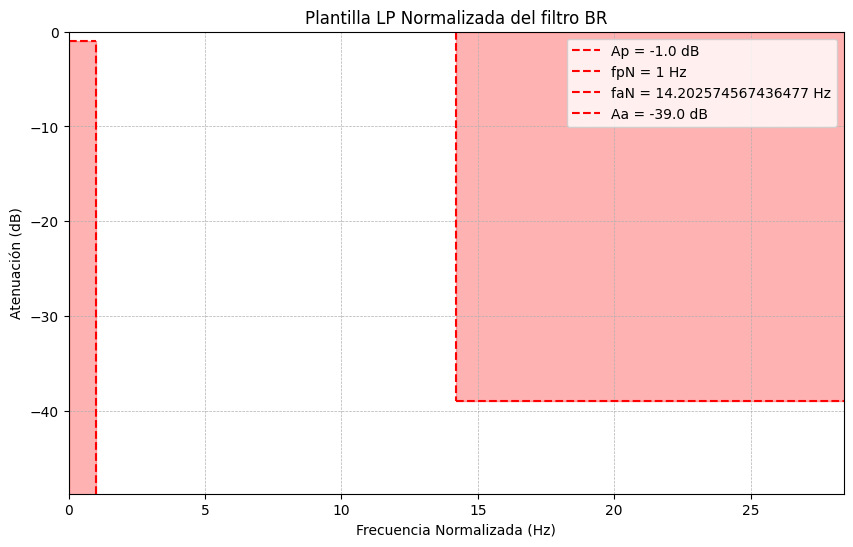

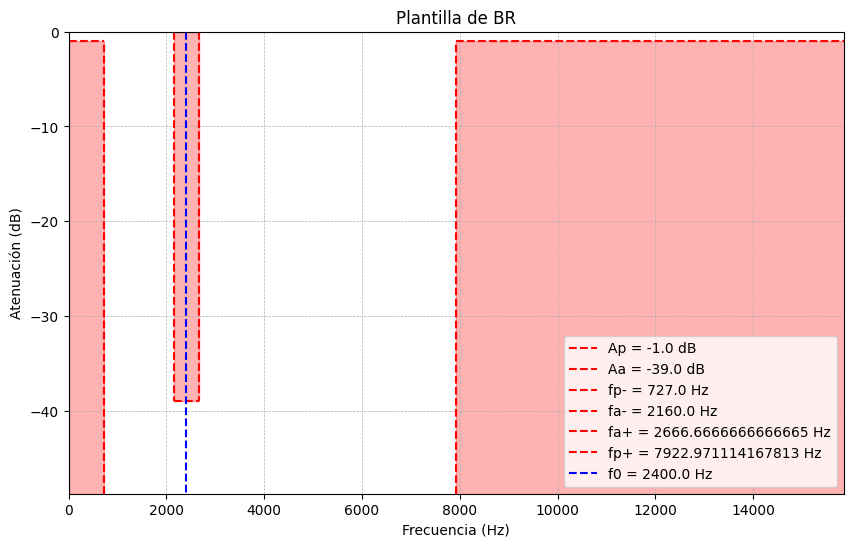

In [192]:

filtro.plotPlantillaNormalizada()

filtro.plotPlantillaArbitraria()



